# ⚡️🏁 Quick start - тестируем простое решение

In [35]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
COLOR_PALETTE = sns.color_palette("Pastel1")
sns.set_palette(COLOR_PALETTE)
COLOR_PALETTE

[(0.984313725490196, 0.7058823529411765, 0.6823529411764706),
 (0.7019607843137254, 0.803921568627451, 0.8901960784313725),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (0.8705882352941177, 0.796078431372549, 0.8941176470588236),
 (0.996078431372549, 0.8509803921568627, 0.6509803921568628),
 (1.0, 1.0, 0.8),
 (0.8980392156862745, 0.8470588235294118, 0.7411764705882353),
 (0.9921568627450981, 0.8549019607843137, 0.9254901960784314),
 (0.9490196078431372, 0.9490196078431372, 0.9490196078431372)]

## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - годы выпуска машины и начала работы в автопарке 
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

In [7]:
# datasets with CSV files:
car_train_filepath = "../data/car_train.csv"
car_test_filepath = "../data/car_test.csv"
driver_info_filepath = "../data/driver_info.csv"
fix_info_filepath = "../data/fix_info.csv"
rides_info_filepath = "../data/rides_info.csv"

In [9]:
# Train
df_train = pd.read_csv(car_train_filepath)
print("Shape", df_train.shape)
df_train.sample(3)

Shape (2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1404,f-1958284u,VW Polo VI,economy,petrol,4.96,2011,5779,2020,6438.71,another_bug
1547,g-1495042h,Smart Coupe,economy,petrol,3.98,2017,122669,2018,2228.86,another_bug
2263,b-1681467p,Kia Sportage,standart,petrol,4.38,2013,43426,2017,1689.59,break_bug


In [54]:
# Test
df_test = pd.read_csv(car_test_filepath)
df_test.sample(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
1605,m97152459x,Smart ForFour,economy,petrol,3.66,2014,64041,2016
1317,W20898223q,VW Polo,economy,petrol,3.30,2011,2708,2014
385,p-1032774f,Nissan Qashqai,standart,petrol,4.52,2014,57496,2021


In [22]:
numerical_features = ["car_rating", "year_to_start", "riders", "year_to_work"]
cat_features = ["model", "car_type", "fuel_type"]
target_cols = ["target_reg", "target_class"]

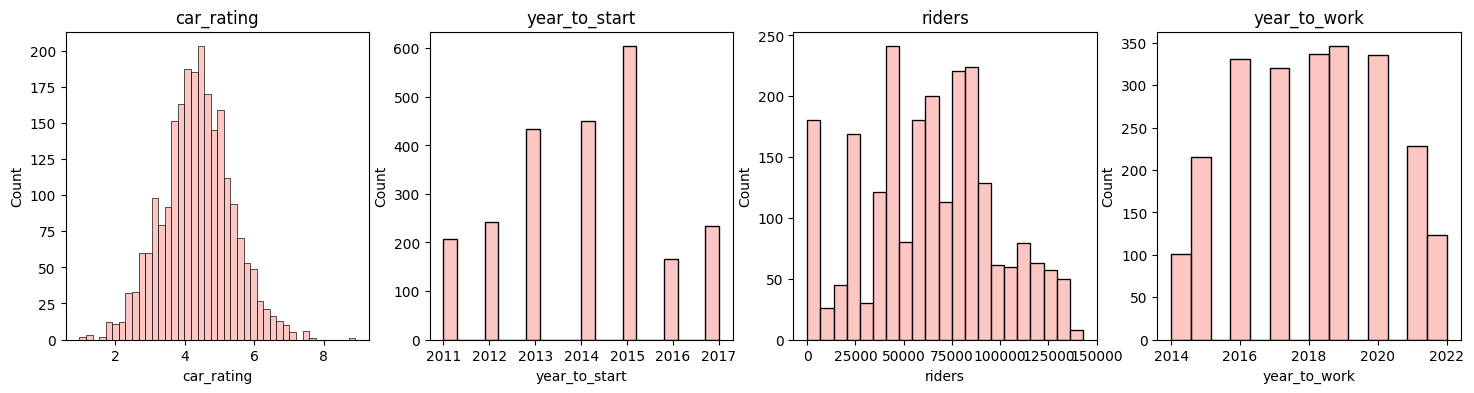

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(18, 4))
for i, col in enumerate(numerical_features):
    ax_i = np.ravel(ax)[i]
    sns.histplot(df_train[col], ax=ax_i)
    ax_i.set_title(col)

## Классифицируем признаки на типы

In [43]:
print("Numerical:", numerical_features)
print("Categorical:", cat_features)
print("Target Columns:", target_cols)

Numerical: ['car_rating', 'year_to_start', 'riders', 'year_to_work']
Categorical: ['model', 'car_type', 'fuel_type']
Target Columns: ['target_reg', 'target_class']


## Обучаем Catboost и делаем прогноз на тест

In [44]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #, mean_squared_error

In [52]:
X = df_train[numerical_features + cat_features]
y = df_train[target_cols[1]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

clf = CatBoostClassifier(
    iterations=2_500,
    learning_rate=0.05,
    depth=4,
    colsample_bylevel=0.5,
    cat_features=cat_features
)


clf.fit(
    X_train,
    y_train, 
    eval_set=(X_test, y_test),
    early_stopping_rounds=250,
    verbose=100,
    plot=False
)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

0:	learn: 2.1931409	test: 2.1965565	best: 2.1965565 (0)	total: 5.06ms	remaining: 12.6s
100:	learn: 2.0957334	test: 2.1881040	best: 2.1876464 (74)	total: 271ms	remaining: 6.45s
200:	learn: 2.0238823	test: 2.1918342	best: 2.1874710 (105)	total: 524ms	remaining: 5.99s
300:	learn: 1.9566830	test: 2.2064582	best: 2.1874710 (105)	total: 784ms	remaining: 5.73s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 2.187471025
bestIteration = 105

Shrink model to first 106 iterations.

 Accuracy: 0.11324786324786325


In [56]:
df_test['target_class'] = clf.predict(df_test[numerical_features + cat_features]).ravel()
df_test[['car_id', 'target_class']].to_csv('../submissions/simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы). 


In [59]:
# Rides
df_rides = pd.read_csv(rides_info_filepath)
df_rides.sample(3)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
536886,B11191837J,l79825102V,L1S,2020-02-21,6.82,20,256,32,48.0,1,557.586601,0,3.789412,-1.657
617373,A43206298m,r19349335d,f1n,2020-01-12,5.64,28,246,27,NaN,2,623.761954,0,8.912278,6.172
302922,S47821730w,V-7306183J,R1A,2020-03-26,4.41,70,627,46,79.0,1,1332.503350,0,21.840912,1.347


In [61]:
df_rides_agg = df_rides.groupby('car_id', as_index=False).agg(
    mean_rating = ('rating', 'mean'),
    distance_sum = ('distance', 'sum'),
    rating_min = ('rating', 'min'),
    speed_max = ('speed_max', 'max'),
    user_ride_quality_median = ('user_ride_quality', 'median'), 
    deviation_normal_count = ('deviation_normal', 'count'),
    user_uniq = ('user_id', lambda x: pd.Series(x).nunique())
)


df_rides_agg.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [71]:
def add_featues(df: pd.DataFrame, features: pd.DataFrame) -> pd.DataFrame:
    if len(set(df.columns[1:]).intersection(features.columns)) > 0:
        raise ValueError("There are common columns dataset in both datasets")

    return df.merge(features, on="car_id", how="left")


df_train_extended = add_featues(df_train, features=df_rides_agg)
df_test_extended = add_featues(df_test, features=df_rides_agg)

# Снова обновляем типы фичей

In [80]:
newly_added_features = list(df_rides_agg.columns[1:])

print('Numerical:', len(numerical_features + newly_added_features), numerical_features + newly_added_features)
print('Categorical:', len(cat_features), cat_features)
print('Targets', target_cols)

Numerical: 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
Categorical: 3 ['model', 'car_type', 'fuel_type']
Targets ['target_reg', 'target_class']


# Обучаем Catboost на новых данных и делаем новый прогноз

In [83]:
X = df_train_extended[numerical_features + newly_added_features + cat_features]
y = df_train_extended['target_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = CatBoostClassifier(
    iterations=2_500,
    learning_rate=0.05,
    depth=4,
    colsample_bylevel=0.5,
    cat_features=cat_features
)

clf.fit(
    X_train,
    y_train, 
    eval_set=(X_test, y_test),
    early_stopping_rounds=250,
    verbose=100,
    plot=False
)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

0:	learn: 2.0398503	test: 2.0447750	best: 2.0447750 (0)	total: 3.67ms	remaining: 9.16s
100:	learn: 0.5787403	test: 0.6349161	best: 0.6349161 (100)	total: 281ms	remaining: 6.68s
200:	learn: 0.4645176	test: 0.5543995	best: 0.5543995 (200)	total: 565ms	remaining: 6.46s
300:	learn: 0.4156750	test: 0.5365005	best: 0.5364922 (299)	total: 863ms	remaining: 6.3s
400:	learn: 0.3801761	test: 0.5328513	best: 0.5321866 (394)	total: 1.16s	remaining: 6.07s
500:	learn: 0.3521789	test: 0.5313711	best: 0.5311666 (466)	total: 1.44s	remaining: 5.76s
600:	learn: 0.3291436	test: 0.5326446	best: 0.5309700 (504)	total: 1.74s	remaining: 5.49s
700:	learn: 0.3081155	test: 0.5348512	best: 0.5309700 (504)	total: 2.02s	remaining: 5.19s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5309699599
bestIteration = 504

Shrink model to first 505 iterations.

 Accuracy: 0.7927350427350427


In [84]:
fi = clf.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,40.296415
1,mean_rating,33.363709
2,rating_min,12.689254
3,user_uniq,3.028377
4,model,2.874279
5,car_type,2.204932
6,user_ride_quality_median,1.415315
7,riders,1.096280
8,car_rating,0.998480
9,distance_sum,0.954943


In [86]:
df_test_extended['target_class'] = clf \
    .predict(df_test_extended[numerical_features + newly_added_features + cat_features]) \
    .ravel()

df_test_extended[['car_id', 'target_class']] \
    .to_csv('../submissions/simple_baseline_v2.csv', index=False)

print('CSV file saved!')

CSV file saved!


# Что дальше? Зашли решение на Kaggle

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Тип сохранения `Save & Run All (Commit)`
- Жмем окончательно кнопку `Save`

**Score: 0.80345**